In [10]:
import numpy as np


class DenseLayer:
    def __init__(self, units=1, activation='relu'):
        self.units = units
        self.activation = activation.lower()
        self.w = None
        self.b = None
        self.input = None
        self.z = None

    def init_weights(self, fan_in):
      if self.activation in ['relu', 'leaky_relu']:
        std = np.sqrt(2.0 / fan_in)
      else:
        std = np.sqrt(1.0 / fan_in)

      self.w = np.random.normal(0.0, std, (fan_in, self.units))
      self.b = np.zeros(self.units)


    def forward(self, x):
        if self.w is None:
          self.init_weights(x.shape[-1])

        self.z = x @ self.w + self.b

        if self.activation == 'relu':
            return np.maximum(0, self.z)

        elif self.activation == 'leaky_relu':
            return np.maximum(0.01 * self.z, self.z)

        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-self.z))

        elif self.activation == 'tanh':
            return np.tanh(self.z)

        elif self.activation == 'softmax':
            exp_z = np.exp(self.z - np.max(self.z, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)

        elif self.activation == 'linear':
            return self.z

        else:
            raise ValueError(f"Неизвестная активация: {self.activation}")

    def derivative(self, a):
        if self.activation == 'relu':
            return (self.z > 0).astype(float)

        elif self.activation == 'leaky_relu':
            return (self.z > 0).astype(float) + 0.01 * (self.z <= 0).astype(float)

        elif self.activation == 'sigmoid':
            return a * (1 - a)

        elif self.activation == 'tanh':
            return 1 - a**2

        elif self.activation == 'linear':
            return np.ones_like(a)

        elif self.activation == 'softmax':
            return np.ones_like(a)

        return np.ones_like(a)


class Input:
    def __init__(self, shape=None):
        self.shape = shape

    def forward(self, x):
        if self.shape is not None:
            expected = self.shape if isinstance(self.shape, tuple) else (self.shape,)
            if x.shape[1:] != expected:
                x = x.reshape((x.shape[0],) + expected)
        return x


class Dropout:
  def __init__(self, rate=0.5):
    self.rate = rate
    self.mask = None
    self.training = True

  def forward(self, x):
    if not self.training:
      return x
    self.mask = (np.random.rand(*x.shape) > self.rate) / (1 - self.rate)
    return x * self.mask


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.history = []
        self.loss_fn = None
        self.loss_deriv = None
        self.l1 = 0
        self.l2 = 0

    def compile(self, loss='mse', l1=0.0, l2=0.0):
      self.l1 = l1
      self.l2 = l2
      self.loss = loss.lower()

      if self.loss == 'mse':
        self.loss_fn = lambda y, p: np.mean((p - y) ** 2)
        self.loss_deriv = lambda y, p: (p - y)

      elif self.loss == 'mae':
        self.loss_fn = lambda y, p: np.mean(np.abs(p - y))
        self.loss_deriv = lambda y, p: np.sign(p - y)

      elif self.loss == 'binary_crossentropy':
        eps = 1e-8
        self.loss_fn = lambda y, p: -np.mean(
            y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
        )
        self.loss_deriv = lambda y, p: (p - y)

      elif self.loss == 'categorical_crossentropy':
        eps = 1e-8
        self.loss_fn = lambda y, p: -np.mean(np.sum(y * np.log(p + eps), axis=1))
        self.loss_deriv = lambda y, p: (p - y)

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def fit(self, x_input, y_input, epochs=100, alpha=0.001, batch_size=32,
            clip_value=5.0, adaptive_alpha=False, Ee=1e-3):
        x_input = np.asarray(x_input, dtype=np.float32)
        y_input = np.asarray(y_input, dtype=np.float32).reshape(-1, 1)

        if y_input.ndim == 1:
          y_input = y_input.reshape(-1, 1)

        n_samples = x_input.shape[0]
        self.history = []

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            x_shuffled = x_input[indices]
            y_shuffled = y_input[indices]

            epoch_loss = 0

            for i in range(0, n_samples, batch_size):
                x = x_shuffled[i:i+batch_size]
                y = y_shuffled[i:i+batch_size]

                if adaptive_alpha:
                  alpha_t = 1.0 / (1 + np.sum(x ** 2))
                else:
                  alpha_t = alpha

                activations = [x]
                for layer in self.layers:
                    if isinstance(layer, Dropout):
                        layer.training = True
                    activations.append(layer.forward(activations[-1]))

                pred = activations[-1]

                loss = self.loss_fn(y, pred)

                reg = 0
                for layer in self.layers:
                  if isinstance(layer, DenseLayer):
                    reg += self.l2 * np.mean(layer.w ** 2) + self.l1 * np.mean(np.abs(layer.w))

                loss += reg
                epoch_loss += loss

                # Обратное распространение
                delta = self.loss_deriv(y, pred)
                for l in range(len(self.layers) - 1, -1, -1):
                    layer = self.layers[l]

                    if isinstance(layer, Input):
                        continue

                    if isinstance(layer, Dropout):
                        delta *= layer.mask
                        continue

                    a_prev = activations[l]
                    da = layer.derivative(activations[l+1])
                    if da is not None:
                      delta *= da

                    grad_w = (a_prev.T @ delta) / x.shape[0]
                    grad_b = np.mean(delta, axis=0)

                    if self.l2:
                      grad_w += 2 * self.l2 * layer.w
                    if self.l1:
                      grad_w += self.l1 * np.sign(layer.w)

                    grad_w = np.clip(grad_w, -clip_value, clip_value)
                    grad_b = np.clip(grad_b, -clip_value, clip_value)

                    layer.w -= alpha_t * grad_w
                    layer.b -= alpha_t * grad_b

                    delta = delta @ layer.w.T

            epoch_loss /= (n_samples // batch_size + 1)
            self.history.append(epoch_loss)

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch:4d} | {self.loss} = {epoch_loss:.6f}")

            if epoch_loss <= Ee:
              print(f"Достигнут критерий остановки: {epoch_loss} <= {Ee}")
              break

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)

        if X.ndim == 1:
            X = X.reshape(1,-1)

        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.training = False

        return self.forward(X)


    def evaluate(self, X, Y):
      if Y.ndim == 1:
          Y = Y.reshape(-1, 1)

      preds = self.forward(X)

      loss = None
      if self.loss_fn is not None:
          loss = self.loss_fn(Y, preds)

      last_activation = getattr(self.layers[-1], "activation_name", None)

      if last_activation == "sigmoid":
          y_hat = (preds >= 0.5).astype(np.float32)
          acc = np.mean(y_hat == Y)
      else:
          acc = None

      return loss, acc

In [31]:
x = np.array([[4, 6], [-4, 6], [4, -6], [-4, -6]], dtype=np.float32)
y = [0, 1, 1, 1]

# BCE + фиксированный шаг
model_1 = Sequential([
    Input(),
    DenseLayer(1, 'sigmoid')
])
model_1.compile(loss='binary_crossentropy')

# BCE + адаптивный шаг.
model_2 = Sequential([
    Input(),
    DenseLayer(1, 'sigmoid')
])
model_2.compile(loss='binary_crossentropy')

# MSE + фиксированный шаг
model_3 = Sequential([
    Input(),
    DenseLayer(1, 'sigmoid')
])
model_3.compile(loss='mse')

# MSE + адаптивный шаг
model_4 = Sequential([
    Input(),
    DenseLayer(1, 'sigmoid')
])
model_4.compile(loss='mse')

In [32]:
model_1.fit(x, y, epochs=100, batch_size=1, alpha=0.01)

Epoch    0 | binary_crossentropy = 4.046098
Epoch   10 | binary_crossentropy = 3.993970
Epoch   20 | binary_crossentropy = 3.935837
Epoch   30 | binary_crossentropy = 3.868639
Epoch   40 | binary_crossentropy = 3.789821
Epoch   50 | binary_crossentropy = 3.700278
Epoch   60 | binary_crossentropy = 3.581597
Epoch   70 | binary_crossentropy = 3.453985
Epoch   80 | binary_crossentropy = 3.306628
Epoch   90 | binary_crossentropy = 3.181729
Epoch   99 | binary_crossentropy = 3.099574


In [33]:
model_2.fit(x, y, epochs=100, batch_size=1, alpha=0.01, adaptive_alpha=True)

Epoch    0 | binary_crossentropy = 0.637127
Epoch   10 | binary_crossentropy = 0.558187
Epoch   20 | binary_crossentropy = 0.454454
Epoch   30 | binary_crossentropy = 0.348736
Epoch   40 | binary_crossentropy = 0.303540
Epoch   50 | binary_crossentropy = 0.290273
Epoch   60 | binary_crossentropy = 0.280097
Epoch   70 | binary_crossentropy = 0.270748
Epoch   80 | binary_crossentropy = 0.262074
Epoch   90 | binary_crossentropy = 0.252794
Epoch   99 | binary_crossentropy = 0.246055


In [35]:
model_3.fit(x, y, epochs=100, batch_size=1, alpha=0.01)

Epoch    0 | mse = 0.166788
Epoch   10 | mse = 0.154451
Epoch   20 | mse = 0.136177
Epoch   30 | mse = 0.115209
Epoch   40 | mse = 0.100392
Epoch   50 | mse = 0.093229
Epoch   60 | mse = 0.089637
Epoch   70 | mse = 0.087102
Epoch   80 | mse = 0.084870
Epoch   90 | mse = 0.082747
Epoch   99 | mse = 0.080910


In [36]:
model_4.fit(x, y, epochs=100, batch_size=1, alpha=0.01, adaptive_alpha=True)

Epoch    0 | mse = 0.592462
Epoch   10 | mse = 0.591969
Epoch   20 | mse = 0.591393
Epoch   30 | mse = 0.590708
Epoch   40 | mse = 0.589871
Epoch   50 | mse = 0.588815
Epoch   60 | mse = 0.587421
Epoch   70 | mse = 0.585463
Epoch   80 | mse = 0.582481
Epoch   90 | mse = 0.577401
Epoch   99 | mse = 0.568742


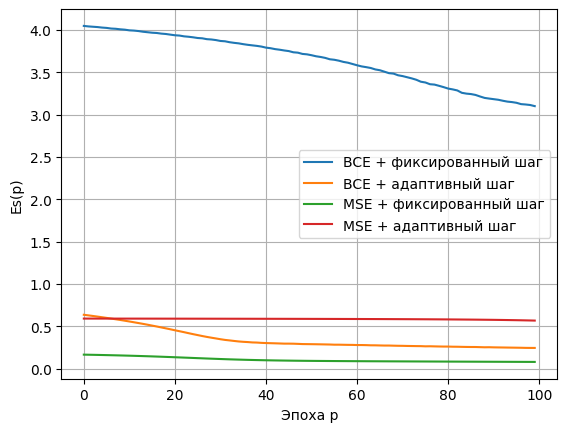

In [38]:
import matplotlib.pyplot as plt


plt.plot(model_1.history, label="BCE + фиксированный шаг")
plt.plot(model_2.history, label="BCE + адаптивный шаг")
plt.plot(model_3.history, label="MSE + фиксированный шаг")
plt.plot(model_4.history, label="MSE + адаптивный шаг")

plt.xlabel("Эпоха p")
plt.ylabel("Es(p)")
plt.legend()
plt.grid()
plt.show()

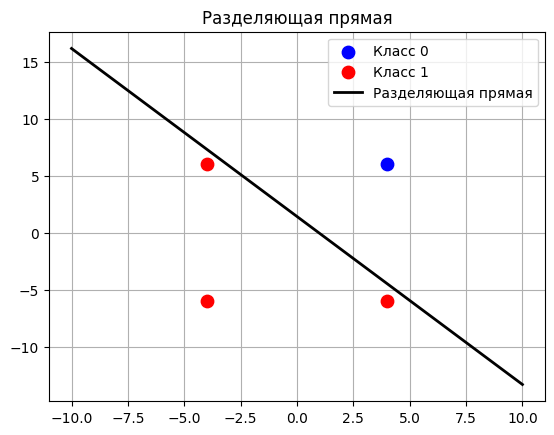

In [39]:
y = np.array(y)

w = model_2.layers[1].w
b = model_2.layers[1].b

x_line = np.linspace(-10, 10, 200)
y_line = -(w[0]/w[1]) * x_line - b[0]/w[1]

plt.scatter(
    x[y == 0, 0],
    x[y == 0, 1],
    color='blue',
    s=80,
    label='Класс 0'
)

plt.scatter(
    x[y == 1, 0],
    x[y == 1, 1],
    color='red',
    s=80,
    label='Класс 1'
)

plt.plot(
    x_line, y_line,
    'k-', linewidth=2,
    label='Разделяющая прямая'
)

plt.grid(True)
plt.title("Разделяющая прямая")
plt.legend()
plt.show()

Введите x1 и x2: 1 -3
Класс: 1, прогноз модели: 0.6725


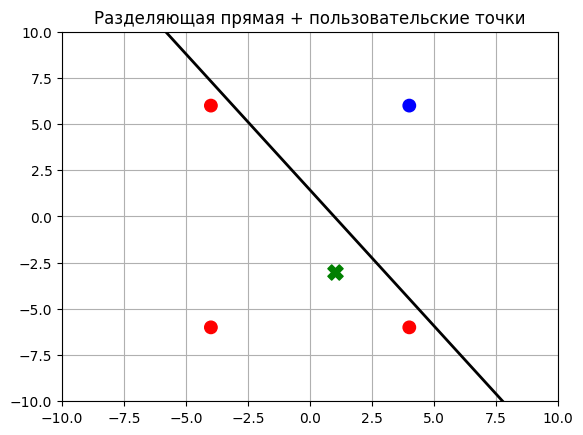

Желаете продолжить? (y/n) n


In [40]:
import matplotlib.pyplot as plt

user_points = []
user_classes = []

while True:
    s = list(map(float, input("Введите x1 и x2: ").split()))

    point = np.array(s, dtype=np.float32)
    x1, x2 = point[0], point[1]

    prediction = model_2.predict(point.reshape(1, -1)).item()
    cls = int(prediction > 0.5)

    print(f"Класс: {cls}, прогноз модели: {prediction:.4f}")

    user_points.append([x1, x2])
    user_classes.append(cls)

    plt.clf()

    plt.scatter(x[:,0], x[:,1], c=y, cmap='bwr', s=80)

    for (px, py), c in zip(user_points, user_classes):
        color = "green" if c == 1 else "yellow"
        plt.scatter([px], [py], c=color, s=120, marker='X')

    plt.plot(x_line, y_line, 'k-', linewidth=2)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True)
    plt.title("Разделяющая прямая + пользовательские точки")

    plt.pause(0.01)

    if input("Желаете продолжить? (y/n) ") == "n":
        break